# Jegadeesh-Titman rolling portfolios

- Relative strength, momentum effect
- Overlapping portfolio returns, Newey-West correction

Copyright 2023, Terence Lim

MIT License

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay
from finds.structured import CRSP, Finder
from finds.recipes import fractiles
from finds.display import show, plot_date
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
imgdir = paths['images']

begyear = 1977
endyear = 2022
retdates = bd.date_range(bd.begyr(begyear), bd.endyr(endyear), 'begmo')
rebaldates = bd.offset(retdates, -1)
percentiles = [20, 80]   # quintile spread percentile breakpoints
maxhold = 6    # hold each monthly-rebalanced portfolio for 6 months

## Overlapping returns: hold monthly spread portfolios for 6 months

In [3]:
mom = []
for rebaldate in rebaldates:
    
    # determine required dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal

    # retrieve universe, required available prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         crsp.get_ret(start, end).rename('mom'),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    df = pd.concat(p, axis=1, join='inner').dropna()

    # quintile spread breakpoints determined from NYSE subset
    tritile = fractiles(values=df['mom'],
                        pct=percentiles,
                        keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # compute and store cap-weighted average returns over maxhold periods
    begret = bd.offset(rebaldate, 1)
    nhold = min(maxhold, len(retdates) - retdates.index(begret))
    endret = bd.endmo(begret, nhold - 1)  # if maxhold is beyond end date
    rets = crsp.get_ret(begret, endret, delist=True)
    ret = rets.reindex(port.index).fillna(0.).mul(port, axis=0).sum()

    mom.append(float(ret) / nhold)

In [7]:
show(DataFrame(data={'mean': np.mean(mom), 'std':np.std(mom)},
               index=['Overlapping Returns']), **SHOW)

,mean,std
Overlapping Spread Returns,0.0044,0.0262


## Non-overlapping: monthly average returns of past 6 months' rebalances

Jegadeesh-Titman rolling portfolios

In [8]:
ports = []  # to roll 6 past portfolios
jt = []
for rebaldate in rebaldates:
    
    # determine required dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal
    
    # retrieve universe, required available prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         crsp.get_ret(start, end).rename('mom'),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    df = pd.concat(p, axis=1, join='inner').dropna()
    
    # quintile spread breakpoints determined from NYSE subset
    tritile = fractiles(values=df['mom'],
                        pct=percentiles,
                        keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # keep only last 6 months' rebalances
    ports.insert(0, port)
    if len(ports) > maxhold:
        ports.pop(-1)

    # compute all portfolios' monthly capwtd returns, and store eqlwtd average
    begret = bd.offset(rebaldate, 1)
    endret = bd.endmo(begret)
    rets = crsp.get_ret(begret, endret, delist=True)
    ret = np.mean([rets.reindex(p.index).fillna(0.).mul(p, axis=0).sum()
                   for p in ports])
    jt.append(ret)

    # adjust stock weights by monthly appreciation
    retx = crsp.get_ret(begret, endret, field='retx')
    ports = [(1+retx.reindex(p.index).fillna(0.)).mul(p, axis=0) for p in ports]

In [9]:
show(DataFrame(data={'mean': np.mean(jt), 'std':np.std(jt)},
               index=['Non-overlapping Returns']), **SHOW)

,mean,std
Non-overlapping Returns,0.0043,0.0455


## Autocorrelations of portfolio returns

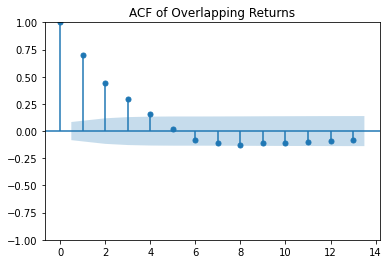

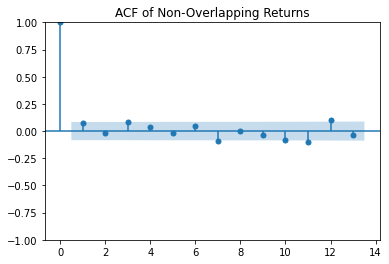

In [10]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(mom,
                         lags=13,
                         title='ACF of Overlapping Returns')
plt.savefig(imgdir / 'overlap.jpg')
sm.graphics.tsa.plot_acf(jt,
                         lags=13,
                         title='ACF of Non-Overlapping Returns')
plt.savefig(imgdir / 'nonoverlap.jpg')

## Newey-West corrected t-stats

In [13]:
res = []
keys = ['All stocks overlapping', 'All stocks non-overlapping']
for out, label in zip([mom, jt], keys):
    data = DataFrame(out, columns=['ret'])
    reg = smf.ols('ret ~ 1',data=data).fit()
    a = Series({stat: round(float(getattr(reg, stat)), 6)
                for stat in ['params','bse','tvalues','pvalues']},
               name='uncorrected')
    #print(reg.summary())
    reg = smf.ols('ret ~ 1',data=data)\
             .fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    # coef, stderr, t-value, P>|z|
    b = Series({stat: round(float(getattr(reg, stat)), 6)
                for stat in ['params','bse','tvalues','pvalues']},
               name='NeweyWest')
    res.append(pd.concat([a, b], axis=1))
show(pd.concat(res, axis=1, keys=keys),
     caption='Uncorrected and Newey-West corrected standard errors', **SHOW)     

All stocks overlapping  \
                                                              uncorrected   
Uncorrected and Newey-West corrected standard e...                          
params                                                             0.0044   
bse                                                                0.0011   
tvalues                                                            3.9503   
pvalues                                                            0.0001   

                                                              \
                                                   NeweyWest   
Uncorrected and Newey-West corrected standard e...             
params                                                0.0044   
bse                                                   0.0020   
tvalues                                               2.1853   
pvalues                                               0.0289   

                                                   All stocks non-overlapping  \
                                                                  uncorrected   
Uncorrected and Newey-West corrected standard e...                              
params                                                                 0.0043   
bse                                                                    0.0019   
tvalues                                                                2.2309   
pvalues                                                                0.0261   

                                                              
                                                   NeweyWest  
Uncorrected and Newey-West corrected standard e...            
params                                                0.0043  
bse                                                   0.0021  
tvalues                                               2.0696  
pvalues                                               0.0385

## Plot monthly average returns of Jegadeesh-Titman rolling portfolios

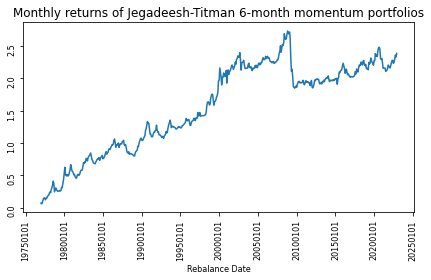

In [17]:
plot_date(DataFrame(index=rebaldates, data=np.cumsum(jt), columns=['momentum']),
          fontsize=8, rotation=90,
          ylabel='Cumulative Returns', xlabel='Rebalance Date',
          title='Monthly returns of Jegadeesh-Titman 6-month momentum portfolios')
plt.savefig(imgdir / 'jegadeesh_titman.jpg')